This notebook walks the user through the process of

- Downloading data from Langlieb et al. 2023 (https://doi.org/10.1101/2023.03.06.531307) and converting it into a MapMyCells-ready h5ad file.
- Submitting that file to the MapMyCells on-line tool for mapping.
- Creating a UMAP embedding of the cells in the downloaded data and visualizing how the MapMyCells cell type assignments are distributed in that embedding.
- Using the quality metrics in the MapMyCells results to perform cuts on the data, and visualizing how those cuts affect the distribution of cell types in the UMAP embedding.

This notebook requires that the user install

- This `cell_type_mapper` library
- `umap-learn`
- [The abc_atlas_access library](https://github.com/AllenInstitute/abc_atlas_access)

In [1]:
import anndata
import gzip
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import scipy
import subprocess
import tempfile
import time
import umap

from abc_atlas_access.abc_atlas_cache.abc_project_cache import (
    AbcProjectCache
)

from cell_type_mapper.utils.utils import (
    mkstemp_clean,
    _clean_up
)

from cell_type_mapper.cell_by_gene.utils import (
    convert_to_cpm
)

from cell_type_mapper.utils.anndata_manipulation import (
    amalgamate_h5ad
)
from cell_type_mapper.utils.anndata_utils import (
    read_df_from_h5ad
)

from cell_type_mapper.taxonomy.taxonomy_tree import (
    TaxonomyTree
)

parent_dir = pathlib.Path(
    "data/demo_20250319"
)
assert parent_dir.is_dir()
metadata_dir = parent_dir / "metadata"
assert metadata_dir.is_dir()

abc_cache_dir = pathlib.Path(
    "data/abc_atlas_data"
)
assert abc_cache_dir.is_dir()
abc_cache = AbcProjectCache.from_cache_dir(abc_cache_dir)

/Users/scott.daniel/miniconda3/envs/mmc_demo/lib/python3.12/site-packages/abc_atlas_access/abc_atlas_cache/cloud_cache.py:630: OutdatedManifestWarning: You are loading releases/20241130/manifest.json. A more up to date version of the dataset -- releases/20250131/manifest.json -- exists online. To see the changes between the two versions of the dataset, run
type.compare_manifests('releases/20241130/manifest.json', 'releases/20250131/manifest.json')
To load another version of the dataset, run
type.load_manifest('releases/20250131/manifest.json')
  warnings.warn(msg, OutdatedManifestWarning)


First download the JSON file describing all of the data available from Langlieb et al. 2023

In [2]:
metadata_url = (
    "https://data.nemoarchive.org/biccn/grant/u19_huang/macosko_regev/sample_file_mapping/sample_to_biccn_files.json"
)
metadata_path = metadata_dir / "sample_to_biccn_files.json"
if not metadata_path.is_file():
    args = [
        "curl",
        "-o",
        str(metadata_path),
        metadata_url
    ]
    process = subprocess.Popen(args)
    process.wait()
print(f"{metadata_path} is available")

data/demo_20250319/metadata/sample_to_biccn_files.json is available


In [3]:
with open(metadata_path, "rb") as src:
    metadata = json.load(src)

Select only those datasets that have been annotated with the anatomical structure "Isocortex".

In [4]:
chosen_datasets = []
for dataset in metadata.values():
    if "isocortex" in dataset["Anatomical Structure (CV)"].lower():
        chosen_datasets.append(dataset)

print(json.dumps(chosen_datasets,indent=2))

[
  {
    "Anatomical Structure (CV)": "Isocortex",
    "Metadata Submission": "2019Q1",
    "Wrangler Notes": null,
    "null": null,
    "sample_id": "PBICCNSMMRCCB4I1FB4D180909",
    "organism": "mouse",
    "taxon_id": "NCBI:txid10090",
    "donor_id": "F001",
    "genotype": "None",
    "modality": "transcriptomics",
    "technique": "10x Chromium 3' v2 sequencing",
    "subspecimen_type": "nuclei",
    "total_processed_subspecimens": "6797",
    "organization": "Cold Spring Harbor Laboratory; Broad Institute",
    "investigator": "Aviv Regev; Evan Macosko",
    "grant_number": "1U19MH114821-01",
    "project": "huang_sn_10xv2",
    "data_archive": "NeMO",
    "r24_directory": "{http://data.nemoarchive.org/biccn/lab/regev/transcriptome/sncell/, http://data.nemoarchive.org/biccn/lab/macosko/transcriptome/sncell/}",
    "comments": "None",
    "files": [
      "http://data.nemoarchive.org/biccn/grant/u19_huang/macosko_regev/transcriptome/sncell/10X_v2/mouse/processed/align/pBICCNsMM

Grab the CellRanger5 packages from the selected datasets.

In [5]:
files_to_download = []
for dataset in chosen_datasets:
    for file_url in dataset['files']:
        if 'CellRanger5' in file_url and file_url.endswith('tar.gz'):
            files_to_download.append(file_url)
print(json.dumps(files_to_download, indent=2))

[
  "http://data.nemoarchive.org/biccn/grant/u19_huang/macosko_regev/transcriptome/sncell/10X_v2/mouse/processed/counts/CellRanger5/pBICCNsMMrCCB4i1FB4d180909.mex.tar.gz",
  "http://data.nemoarchive.org/biccn/grant/u19_huang/macosko_regev/transcriptome/sncell/10X_v2/mouse/processed/counts/CellRanger5/pBICCNsMMrCCJ2i1FJ2d180912.mex.tar.gz",
  "http://data.nemoarchive.org/biccn/grant/u19_huang/macosko_regev/transcriptome/sncell/10X_v2/mouse/processed/counts/CellRanger5/pBICCNsMMrCCK2i1FK2d180912b.mex.tar.gz"
]


Download those files to the local system as needed.

In [6]:
data_dir = parent_dir / 'raw_data'
assert data_dir.is_dir()
for file_url in files_to_download:
    file_url = file_url.replace('http://', 'https://')
    file_name = file_url.split('/')[-1]
    file_path = data_dir / file_name
    if not file_path.is_file():
        args = [
            "curl",
            "-o",
            str(file_path),
            file_url
        ]
        process = subprocess.Popen(args)
        process.wait()
    print(f'{file_path} is available')

data/demo_20250319/raw_data/pBICCNsMMrCCB4i1FB4d180909.mex.tar.gz is available
data/demo_20250319/raw_data/pBICCNsMMrCCJ2i1FJ2d180912.mex.tar.gz is available
data/demo_20250319/raw_data/pBICCNsMMrCCK2i1FK2d180912b.mex.tar.gz is available


Define some helper functions

In [7]:
def get_open_fn(file_path):
    """
    Determine whether the file at file_path can be opened with
    open() or if it needs gzip_open()

    Parameters
    ---------
    file_path:
        path to the file in question

    Returns
    -------
    A dict
        {'fn': the function with which to open the file
         'mode': the mode ('r' or 'rb') in which to open the file
         'is_gzip': boolean indicating if the file has been gzipped}
    """
    open_fn = open
    open_mode = 'r'
    is_gzip = False
    if file_path.name.endswith('gz'):
        open_fn = gzip.open
        open_mode = 'rb'
        is_gzip = True
    return {
        'fn': open_fn,
        'mode': open_mode,
        'is_gzip': is_gzip
    }

In [8]:
def create_var(gene_file_path):
    """
    Create and return the var dataframe from a gene.tsv file at gene_file_path
    """
    gene_symbols = []
    gene_identifiers = []
    symbol_to_ct = dict()

    open_params = get_open_fn(gene_file_path)

    with open_params['fn'](gene_file_path, mode=open_params['mode']) as src:
        for line in src:
            if open_params['is_gzip']:
                line = line.decode()
            line = line.split()
            identifier = line[0]
            symbol = line[1]
            gene_identifiers.append(identifier)
            gene_symbols.append(symbol)
            if symbol not in symbol_to_ct:
                symbol_to_ct[symbol] = 0
            symbol_to_ct[symbol] += 1

    # in cases where a symbol maps to more than one EnsemblID,
    # just use the EnsemblID
    gene_list = []
    for symbol, identifier in zip(gene_symbols, gene_identifiers):
        if symbol_to_ct[symbol] == 1:
            gene_list.append(symbol)
        else:
            gene_list.append(identifier)

    assert len(set(gene_list)) == len(gene_list)

    var = pd.DataFrame(
        [{'gene_id': g} for g in gene_list]).set_index('gene_id')

    return var

In [9]:
def create_obs(barcode_file_path, matrix_file_path, min_genes=0):
    """
    Create and return the obs dataframe for a single barcode file

    Parameters
    ----------
    barcode_file_path:
        path to the barcode.tsv file
    matrix_file_path:
        path to the corresponding matrix.tsv file
    min_genes:
        an int; the minimum number of non-zero genes a cell must possess
        to be included in the h5ad file

    Returns
    -------
    obs:
        the obs dataframe for a single h5ad file
    valid_cells:
        the set of integers indicating the rows of
        barcode.tsv that passed the min_genes test
    cell_idx_transform:
        a dict mapping the rows of barcode.tsv to the rows
        of obs (i.e. to the cells that passed the min_genes test)
    """

    # read the barcodes of the cells
    open_params = get_open_fn(barcode_file_path)
    cell_list = []
    with open_params['fn'](barcode_file_path, open_params['mode']) as src:
        for line in src:
            if open_params['is_gzip']:
                line = line.decode()
            cell_list.append(line.strip())

    # determine how many
    open_params = get_open_fn(matrix_file_path)
    cell_idx = []
    with open_params['fn'](matrix_file_path, open_params['mode']) as src:
        src.readline()
        src.readline()
        src.readline()
        for line in src:
            if open_params['is_gzip']:
                line = line.decode()
            cell_idx.append(int(line.strip().split()[1])-1)

    cell_idx = np.array(cell_idx)

    unq_idx, ct = np.unique(cell_idx, return_counts=True)
    valid_cell_idx = np.sort(unq_idx[(ct>=min_genes)])
    print(f'{len(valid_cell_idx)} of {len(unq_idx)}')
    cell_list = [cell_list[ii] for ii in valid_cell_idx]

    # dict mapping old cell idx to new cell idx
    cell_idx_transform = {old:new for new, old in enumerate(valid_cell_idx)}

    valid_cells = set(valid_cell_idx)

    obs = pd.DataFrame(
        [{'barcode': c} for c in cell_list]).set_index('barcode')
    return obs, valid_cells, cell_idx_transform


In [10]:
def create_cell_by_gene(
        matrix_file_path,
        obs,
        var,
        valid_cells,
        cell_idx_transform):
    """
    Create the cell-by-gene matrix for an h5ad file

    Parameters
    ----------
    matrix_file_path:
        path to the matrix.tsv file
    obs:
        the obs dataframe for the h5ad file
    var:
        the var dataframe for the h5ad_file
    valid_cells:
        integer indices of valid cells (returned by create_obs)
    cell_idx_transform:
        dict mapping rows of barcodes.tsv to rows of obs
        (returned by create_obs)

    Returns
    -------
    The cell-by-gene matrix (as a sparse array) for the h5ad file
    """
    # Put together the cell-by-gene matrix

    row_idx = []
    col_idx = []
    counts = []
    open_params = get_open_fn(matrix_file_path)
    with open_params['fn'](matrix_file_path, open_params['mode']) as src:
        src.readline()
        src.readline()
        src.readline()
        for line in src:
            if open_params['is_gzip']:
                line = line.decode()
            params = line.strip().split()
            this_gene = int(params[0])-1
            this_cell = int(params[1])-1
            this_ct = int(params[2])
            if this_cell in valid_cells:
                row_idx.append(cell_idx_transform[this_cell])
                col_idx.append(this_gene)
                counts.append(this_ct)

    X_data = scipy.sparse.csr_matrix(
        (
         counts,
         (row_idx, col_idx)
        ),
        shape=(len(obs), len(var))
    )
    return X_data


In [11]:
def create_h5ad(
        raw_path,
        dst_path,
        tmp_dir):
    """
    Read the data from a gzipped tarball downloaded from NEMO and convert it to
    an h5ad file

    Parameters
    ----------
    raw_path:
        path to the gzipped tarball downloaded from NEMO
    dst_path:
        path to the h5ad file that will be created
    tmp_dir:
        directory where temporary files can be written

    Returns
    -------
    Path to written h5ad file
    """
    unzip_dir = pathlib.Path(
        tempfile.mkdtemp(
            dir=tmp_dir
        )
    )

    args = [
        "tar",
        "-xvf",
        str(raw_path),
        "--directory",
        str(unzip_dir)
    ]
    process = subprocess.Popen(args)
    process.wait()

    unzip_dir = [n for n in unzip_dir.iterdir() if n.is_dir()][0]
    
    gene_file_path = unzip_dir / 'genes.tsv'
    if not gene_file_path.is_file():
        gene_file_path = unzip_dir / 'features.tsv.gz'
    if not gene_file_path.is_file():
        gene_file_path = unzip_dir / 'features.tsv'
    if not gene_file_path.is_file():
        raise RuntimeError(f"{gene_file_path} not a file")

    barcode_file_path = unzip_dir / 'barcodes.tsv'
    if not barcode_file_path.is_file():
        barcode_file_path = unzip_dir / 'barcodes.tsv.gz'
    if not barcode_file_path.is_file():
        raise RuntimeError(f"{barcode_file_path} not a file")

    matrix_file_path = unzip_dir / 'matrix.mtx'
    if not matrix_file_path.is_file():
        matrix_file_path = unzip_dir / 'matrix.mtx.gz'
    if not matrix_file_path.is_file():
        raise RuntimeError(f"{matrix_file_path} not a file")

    var = create_var(
        gene_file_path=gene_file_path
    )

    (obs,
     valid_cells,
     cell_idx_transform) = create_obs(
        barcode_file_path=barcode_file_path,
        matrix_file_path=matrix_file_path,
        min_genes=0)

    cell_by_gene = create_cell_by_gene(
        matrix_file_path=matrix_file_path,
        obs=obs,
        var=var,
        valid_cells=valid_cells,
        cell_idx_transform=cell_idx_transform
    )

    a_data = anndata.AnnData(
        obs=obs,
        var=var,
        X=cell_by_gene
    )
    print(f'writing to {dst_path}')
    a_data.write_h5ad(dst_path)
    return dst_path


Loop over the downloaded tarballs. Convert each into an individual h5ad file.

In [12]:
tmp_output_dir = parent_dir / 'unzipped'
assert tmp_output_dir.is_dir()

output_dir = parent_dir / 'processed_data'
assert output_dir.is_dir()

tmp_dir = pathlib.Path(
    tempfile.mkdtemp(
        dir=tmp_output_dir
   )
)

raw_data_paths = [n for n in data_dir.rglob('*.tar.gz')]

h5ad_path_list = []

try:
    for data_path in raw_data_paths:
        dst_path = output_dir / f'{data_path.name}.h5ad'
        h5ad_path_list.append(
            create_h5ad(
                raw_path=data_path,
                dst_path=dst_path,
                tmp_dir=tmp_dir
            )
        )
finally:
    _clean_up(tmp_dir)

x pBICCNsMMrCCJ2i1FJ2d180912/matrix.mtx
x pBICCNsMMrCCJ2i1FJ2d180912/barcodes.tsv
x pBICCNsMMrCCJ2i1FJ2d180912/features.tsv


1508 of 1508
writing to data/demo_20250319/processed_data/pBICCNsMMrCCJ2i1FJ2d180912.mex.tar.gz.h5ad


x pBICCNsMMrCCK2i1FK2d180912b/matrix.mtx
x pBICCNsMMrCCK2i1FK2d180912b/barcodes.tsv
x pBICCNsMMrCCK2i1FK2d180912b/features.tsv


7937 of 7937
writing to data/demo_20250319/processed_data/pBICCNsMMrCCK2i1FK2d180912b.mex.tar.gz.h5ad


x pBICCNsMMrCCB4i1FB4d180909/matrix.mtx
x pBICCNsMMrCCB4i1FB4d180909/barcodes.tsv
x pBICCNsMMrCCB4i1FB4d180909/features.tsv


7633 of 7633
writing to data/demo_20250319/processed_data/pBICCNsMMrCCB4i1FB4d180909.mex.tar.gz.h5ad


In [13]:
def create_joint_h5ad(input_path_list, dst_path):
    """
    Combine the contents of several h5ad files into a single h5ad file
    containing all of their data.

    Parameters
    ----------
    input_path_list:
        list of h5ad files to be combined
    dst_path:
        path to the combined h5ad file that will be written

    Returns
    -------
    None
        data is written to dst_path
    """
    config = []
    obs_records = []
    dst_var = None
    for h5ad_path in input_path_list:
        file_name = h5ad_path.name
        obs = read_df_from_h5ad(h5ad_path, df_name='obs')
        n_cells = len(obs)
        var = read_df_from_h5ad(h5ad_path, df_name='var')
        if dst_var is None:
            dst_var = var
        else:
            assert var.equals(dst_var)
        these_records = obs.reset_index().to_dict(orient='records')
        obs_records += [
            {'barcode': r['barcode'],
             'cell_id': f"{r['barcode']}_{file_name}",
             'file': file_name}
             for r in these_records
        ]
        config.append(
            {'path': h5ad_path,
             'rows': list(range(n_cells)),
             'layer': 'X'
             }
        )

    dst_obs = pd.DataFrame(obs_records)
    assert len(dst_obs['cell_id'].values) == len(np.unique(dst_obs['cell_id'].values))
    dst_obs = dst_obs.set_index('cell_id')

    amalgamate_h5ad(
        src_rows=config,
        dst_path=dst_path,
        dst_obs=dst_obs,
        dst_var=dst_var,
        tmp_dir=None,
        compression=True,
        dst_sparse=True)

    print(f'WROTE {dst_path}')

Combine the individual h5ad files into one file.

In [14]:
joint_h5ad_path = parent_dir / 'processed_data/isocortex_data.h5ad'
create_joint_h5ad(
    input_path_list=h5ad_path_list,
    dst_path=joint_h5ad_path
)

1 of 3 packets in 5.91e-02 sec; predict 1.18e-01 sec of 1.77e-01 sec left
2 of 3 packets in 2.97e-01 sec; predict 1.49e-01 sec of 4.46e-01 sec left
3 of 3 packets in 6.14e-01 sec; predict 0.00e+00 sec of 6.14e-01 sec left
joining files
1 of 3 tmp files in 1.90e-01 sec; predict 3.79e-01 sec of 5.69e-01 sec left
2 of 3 tmp files in 1.48e+00 sec; predict 7.41e-01 sec of 2.22e+00 sec left
3 of 3 tmp files in 2.91e+00 sec; predict 0.00e+00 sec of 2.91e+00 sec left
WROTE data/demo_20250319/processed_data/isocortex_data.h5ad


**Submit the file above for mapping with [MapMyCells](https://knowledge.brain-map.org/mapmycells/process/)**. Select the Whole Mouse Brain taxonomy, hierarchical mapping algorthm. Download the mapping file into `data/demo_20250319/mappings`. The cells below will process the newest file in that directory.

Unzip the newest mapping file.

In [15]:
mappings_dir = parent_dir / "mappings"
assert mappings_dir.is_dir()
unzipped_mappings_dir = mappings_dir / "unzipped"
assert unzipped_mappings_dir.is_dir()

file_list = [n for n in unzipped_mappings_dir.iterdir() if 'gitignore' not in n.name]
for file_path in file_list:
    file_path.unlink()

available_mappings = sorted(
    [str(n) for n in mappings_dir.iterdir()
    if n.is_file() and n.name.startswith('isocortex_data')]
)[-1::-1]

args = [
    "unzip",
    str(available_mappings[0]),
    "-d",
    str(unzipped_mappings_dir)
]
process = subprocess.Popen(args)
process.wait()

Archive:  data/demo_20250319/mappings/isocortex_data_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1741880174596.zip
 extracting: data/demo_20250319/mappings/unzipped/isocortex_data_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1741880174596.json  
 extracting: data/demo_20250319/mappings/unzipped/isocortex_data_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1741880174596.csv  
 extracting: data/demo_20250319/mappings/unzipped/validation_log.txt  
 extracting: data/demo_20250319/mappings/unzipped/isocortex_data_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1741880174596_summary_metadata.json  


0

Open and read the results of the mapping.

In [16]:
json_results_path = [
    n for n in unzipped_mappings_dir.rglob('*.json') if 'summary_metadata' not in n.name
][0]

In [17]:
with open(json_results_path, 'rb') as src:
    mmc = json.load(src)
taxonomy_tree = TaxonomyTree(data=mmc['taxonomy_tree'])
results = {cell['cell_id']: cell for cell in mmc['results']}
del mmc

/Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/src/cell_type_mapper/taxonomy/utils.py:253: UserWarning: This taxonomy has no mapping from leaf_node -> rows in the cell by gene matrix
  warnings.warn("This taxonomy has no mapping from leaf_node -> rows "


Define some visualization helper functions.

In [18]:
def plot_metric_distributions(
        results,
        taxonomy_tree,
        metric,
        dst_path=None,
        fontsize=15):
    """
    Plot the distribution of quality metrics for the mapped data at
    each level of the taxonomy.

    Parameters
    ----------
    results:
        a dict mapping cell_id to the mapping results for that cell
    taxonomy_tree:
        a TaxonomyTree definining the taxonomy mapped to
    metric:
        a string specifying the metric to plot, either
        "avg_correlation", "bootstrapping_probability", or
        "aggregate_probability"
    dst_path:
        Optional path to where the figure will be saved
        (in addition to being visualized in this notebook)
    fontsize:
        size of font in visualization
    """
    n_levels = len(taxonomy_tree.hierarchy)
    n_rows = np.round(np.sqrt(n_levels)).astype(int)
    fig = plt.figure(figsize=(n_rows*5, n_rows*5))
    axis_lookup = {
        level: fig.add_subplot(n_rows, n_rows, ii+1)
        for ii, level in enumerate(taxonomy_tree.hierarchy)
    }
    for level in taxonomy_tree.hierarchy:
        level_name = taxonomy_tree.level_to_name(level)
        axis = axis_lookup[level]
        metric_values = np.array([
            cell[level][metric] for cell in results.values()
        ])
        axis.hist(metric_values, bins=100)
        axis.set_title(f'{level_name}')
        axis.set_xlabel(metric)
        axis.tick_params(which='both', axis='both', size=fontsize)

    fig.tight_layout()
    if dst_path is not None:
        fig.savefig(dst_path)
    fig.show()

/var/folders/6w/ny22h74j3sz8jdt_69ljc9srvkqr8_/T/ipykernel_78560/701076492.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


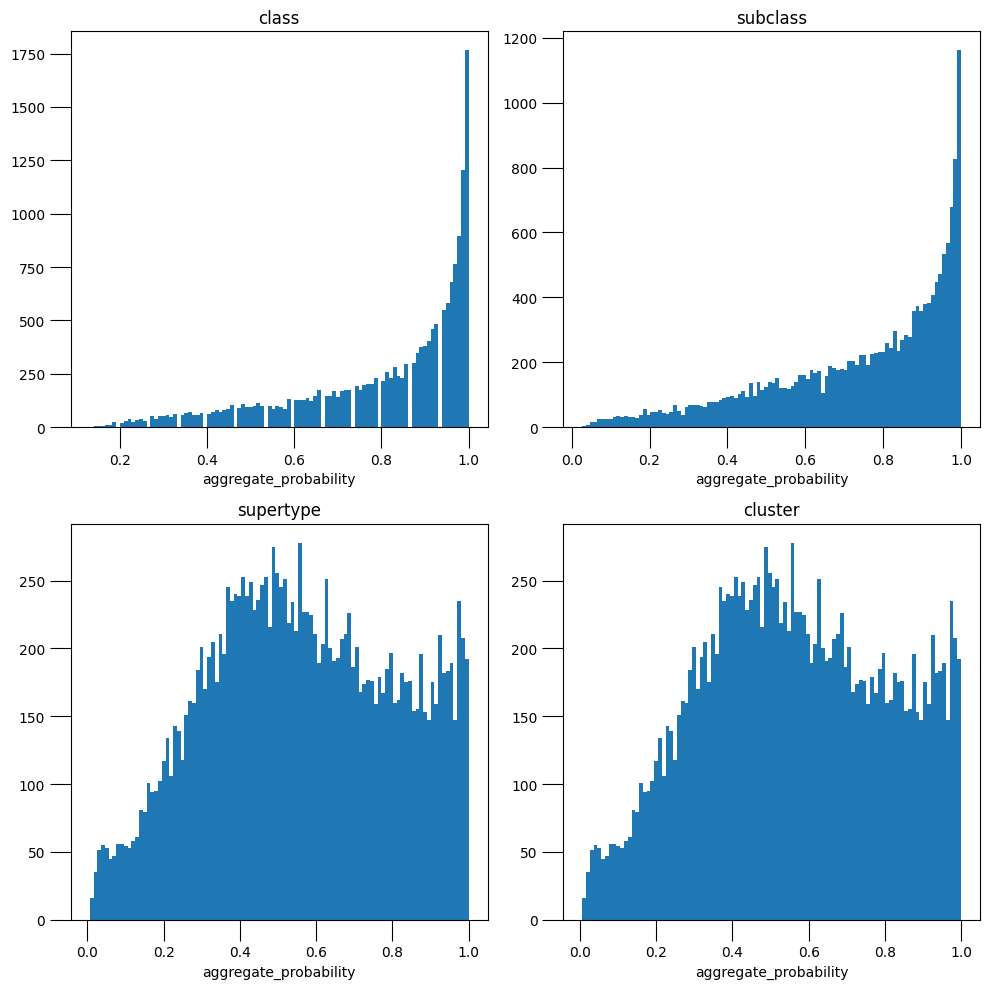

In [19]:
plot_metric_distributions(
    results=results,
    taxonomy_tree=taxonomy_tree,
    metric='aggregate_probability')

/var/folders/6w/ny22h74j3sz8jdt_69ljc9srvkqr8_/T/ipykernel_78560/701076492.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


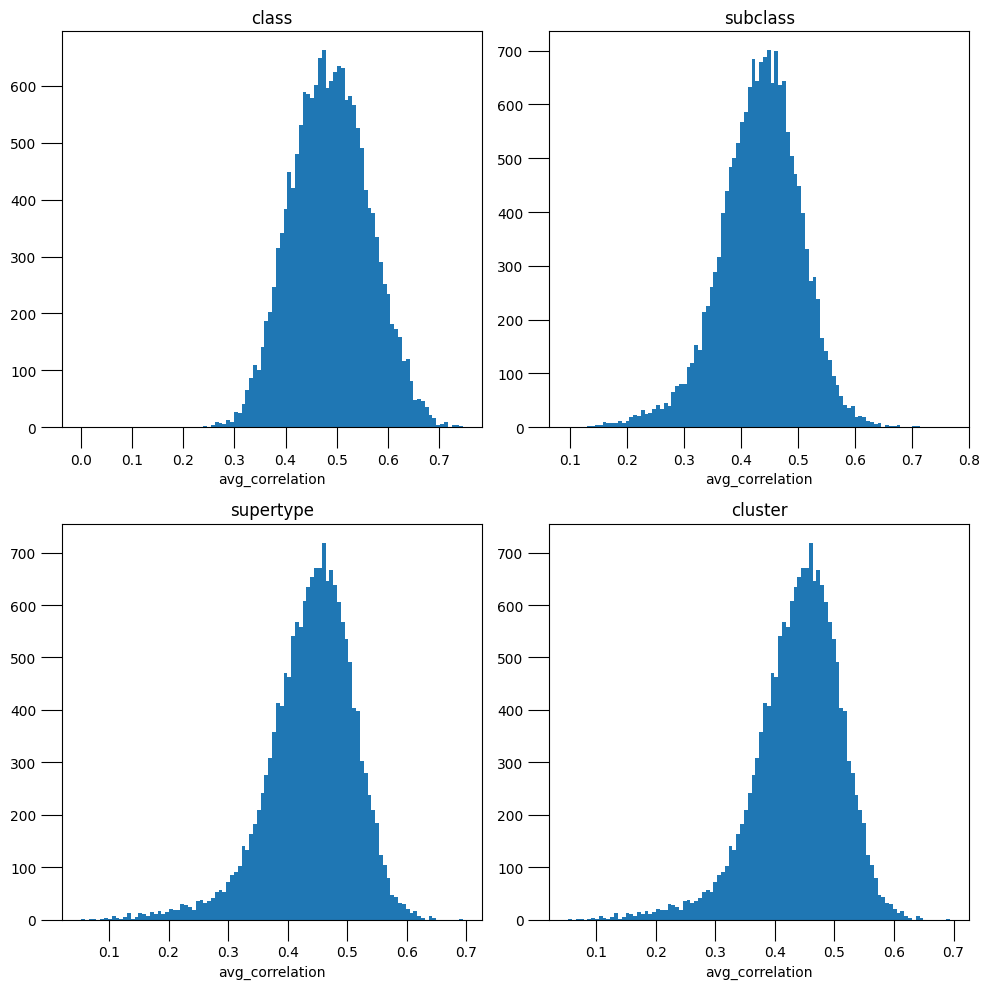

In [20]:
plot_metric_distributions(
    results=results,
    taxonomy_tree=taxonomy_tree,
    metric='avg_correlation')

In [21]:
def create_umap_coords(mapping_path, h5ad_data_path, dst_path):
    """
    Create a UMAP embedding for the data by subselecting the full
    data down to only the marker genes used by MapMyCells and
    running umap.fit_transform on that data

    Parameters
    ----------
    mapping_path:
        path to the JSON file produced by MapMyCells
    h5ad_data_path:
        path to the h5ad file that was mapped
    dst_path:
        path to CSV file where UMAP coords will be saved
    """

    # get marker genes used by MapMyCells, as well as mapping
    # between ENSEMBL ID and input gene symbols used for this
    # mapping
    with open(mapping_path, 'rb') as src:
        mmc = json.load(src)
    gene_mapping = mmc['gene_identifier_mapping']
    marker_genes = mmc['marker_genes']
    del mmc    

    ens_to_sym = {
        gene_mapping[k]: k
        for k in gene_mapping
    }

    src = anndata.read_h5ad(h5ad_data_path, backed='r')
    symbol_to_idx = {
        g:ii for ii, g in enumerate(src.var.index.values)
    }

    # downsample cell-by-gene matrix to only include
    # marker genes
    marker_set = set()
    for k in marker_genes:
        if k in ('log', 'metadata'):
            continue
        marker_set = marker_set.union(set(marker_genes[k]))

    chosen_idx = []
    for e in marker_set:
        if e in ens_to_sym:
            idx = symbol_to_idx[ens_to_sym[e]]
        else:
            idx = symbol_to_idx[e]
        chosen_idx.append(idx)

    chosen_idx = np.array(chosen_idx)
    chosen_idx = np.sort(chosen_idx)

    assert len(chosen_idx) == len(np.unique(chosen_idx))

    x_dense = src.X.to_memory().toarray().astype(np.int16)
    x_dense = convert_to_cpm(x_dense)
    x_dense = np.log2(x_dense+1.0)

    x_dense = x_dense[:, chosen_idx]

    # produce UMAP embedding of downsampled data
    reducer = umap.UMAP()
    t0 = time.time()
    print('starting')
    embedding = reducer.fit_transform(
        x_dense
    )
    dur = time.time()-t0
    print(f'embedding took {dur:.2e} seconds')
    print(embedding.shape)
    print(type(embedding))

    # save as CSV file
    coords = [
        {'cell_id': cell_id,
         'x': embedding[ii, 0],
         'y': embedding[ii, 1]}
        for ii, cell_id in enumerate(src.obs.index.values)
    ]
    coords = pd.DataFrame(coords)
    coords.to_csv(dst_path, index=False)

In [22]:
umap_csv_path = parent_dir / 'processed_data/isocortex_umap.csv'
create_umap_coords(
    mapping_path=json_results_path,
    h5ad_data_path=joint_h5ad_path,
    dst_path=umap_csv_path)

starting


/Users/scott.daniel/miniconda3/envs/mmc_demo/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


embedding took 4.12e+01 seconds
(17078, 2)
<class 'numpy.ndarray'>


Create a dict mapping cell type taxons to their canonical colors (as used in ABC Atlas)

In [23]:
color_df = abc_cache.get_metadata_dataframe(
    directory='WMB-taxonomy',
    file_name='cluster_annotation_term'
)

color_map = dict()
for label, level, color in zip(
        color_df.label.values,
        color_df.cluster_annotation_term_set_label.values,
        color_df.color_hex_triplet.values):
    if level not in color_map:
        color_map[level] = dict()
    color_map[level][label] = color

In [24]:
umap_df = pd.read_csv(umap_csv_path)


In [25]:
def unpack_umap_df(df):
    """
    Read dataframe containing UMAP embedding, return numpy arrays

    Parameters
    ----------
    df:
        dataframe containing UMAP embedding

    Returns
    -------
    A dict
        {'coords': (n_cells, 2) array containing UMAP coordinates
         'id': (n_cells,) array of cell_ids}
    """
    umap_coords = np.vstack([df.x.values, df.y.values]).transpose()
    umap_id = df.cell_id.values
    return {
        'coords': umap_coords,
        'id': umap_id
    }

In [26]:
def calculate_uniformity(
        umap_df,
        results,
        taxonomy_level,
        k_nn=20):
    """
    For each mapped cell, find its k_nn neighbors in UMAP
    space. Determine how many of those neighbors are
    assigned the same taxon as the cell (this is a measure
    of how "in place" or "out of place" in the UMAP plot
    a cell is, based on its type assignment).

    Parameters
    ----------
    umap_df:
        dataframe containing UMAP embedding
    results:
        dict mapping cell_id to the cell type mapping result
        for that cell
    taxonomy_level:
        level in the taxonomy for which to compute the "uniformity"
    k_nn:
        an int; the number of nearest neighbors to consider

    Returns
    -------
    A numpy array indicating how many of each cell's k_nn
    neighbors have the same assignment at taxonomy_level
    """
    umap_data = unpack_umap_df(umap_df)
    umap_coords = umap_data['coords']
    umap_id = umap_data['id']
    
    kd_tree = scipy.spatial.cKDTree(umap_coords)
    nn_arr = kd_tree.query(
        kd_tree.data,
        k=k_nn+1
    )[1][:, 1:]
    uniformity = []
    for idx, cell_id in enumerate(umap_id):
        this = results[cell_id][taxonomy_level]['assignment']
        n_same = sum([
            results[umap_id[jj]][taxonomy_level]['assignment'] == this
            for jj in nn_arr[idx, :]
        ])
        uniformity.append(n_same)
    return np.array(uniformity)

In [27]:
def _create_single_scatter(
        axis,
        xx,
        yy,
        color,
        label,
        marker_size,
        fontsize,
        skip_legend=False):
    axis.scatter(xx, yy, c=color, s=marker_size)

    if skip_legend:
        return
    
    unq_label_list, unq_ct = np.unique(label, return_counts=True)
    if len(unq_label_list) > 30:
        return
    
    xlim = axis.get_xlim()
    ylim = axis.get_ylim()
    dx = xlim[1]-xlim[0]
    xlim = (xlim[0], xlim[1]+dx)


    legx = xlim[1]+20.0
    legy = ylim[1]+20.0
    
    # add dummy data so we can create a legend
    for unq_label, ct in zip(unq_label_list, unq_ct):
        valid = np.where(label==unq_label)[0][0]
        axis.scatter(
            legx,
            legy,
            c=color[valid],
            s=marker_size*20,
            label=f'{label[valid]} ({ct} cells)'
        )
    
    axis.set_xlim(xlim)
    axis.set_ylim(ylim)
    axis.legend(loc=0, fontsize=fontsize)


In [28]:
def plot_umap(
        results,
        taxonomy_level,
        taxonomy_tree,
        umap_df,
        color_map,
        cut_on,
        cut,
        size_unit=5,
        marker_size=3,
        fontsize=10,
        dst_path=None):
    """
    Generate a UMAP plot

    Parameters
    ----------
    results:
        dict mapping cell_id to the cell type mapping result
        for that cell
    taxonomy_level:
        level in the taxonomy at which to perform the plot
    taxonomy_tree:
        a TaxonomyTree defining the taxonomy mapped to
    umap_df:
        dataframe containing UMAP embedding
    color_map:
        dict mapping [level][taxon] to color hex code
    cut_on:
        metric on which to peform quality cut, either
        'probability' (implying 'aggregate_probability')
        or 'correlation' (implying 'avg_correlation')
    size_unit:
        controls size of whole plot
    marker_size:
        size of dots in UMAP plot
    fontsize:
        size of font in plots
    dst_path:
        optional path to which plot will be saved
        (in addition to being visualized in this notebook)

    Returns
    -------
    None
        plot is visualized in this notebook and optionally
        saved in dst_path
    """
    if cut_on not in ('probability', 'correlation'):
        raise RuntimeError(
            "cut_on must be either 'probability' or 'correlation'; "
            f"you gave{cut_on}"
        )
    
    level_label = taxonomy_tree.level_to_name(taxonomy_level)
    
    uniformity = calculate_uniformity(
        results=results,
        taxonomy_level=taxonomy_level,
        umap_df=umap_df,
        k_nn=20
    )

    umap_data = unpack_umap_df(
        umap_df
    )
    umap_coords = umap_data['coords']
    umap_id = umap_data['id']
    
    xx = umap_coords[:, 0]
    yy = umap_coords[:, 1]
    color = np.array([
        color_map[taxonomy_level][results[cell_id][taxonomy_level]['assignment']]
        for cell_id in umap_id
    ])
    prob = np.array(
        [results[cell_id][taxonomy_level]['aggregate_probability']
         for cell_id in umap_id]
    )
    corr = np.array(
        [results[cell_id][taxonomy_level]['avg_correlation']
         for cell_id in umap_id]
    )
    label = np.array([
        taxonomy_tree.label_to_name(
            level=taxonomy_level,
            label=results[cell_id][taxonomy_level]['assignment']
        )
        for cell_id in umap_id
    ])

    n_label = len(set(label))
    
    #all_idx = np.arange(len(xx), dtype=int)
    #rng.shuffle(all_idx)
    all_idx = np.argsort(uniformity)[-1::-1]
    xx = xx[all_idx]
    yy = yy[all_idx]
    prob = prob[all_idx]
    corr = corr[all_idx]
    color = color[all_idx]
    label = label[all_idx]

    if n_label > 30:
        fig = plt.figure(figsize=(3*size_unit, size_unit))
        axis_list = [
            fig.add_subplot(1,3,ii+1) for ii in range(3)
        ]
    else:
        fig = plt.figure(figsize=(3.5*size_unit, size_unit))
        axis_list = []
        axis_list.append(fig.add_subplot(1, 2, 1))
        axis_list.append(fig.add_subplot(1, 4, 3))
        axis_list.append(fig.add_subplot(1, 4, 4))


    if cut_on == "probability":
        valid = (prob >= cut)
    elif cut_on == "correlation":
        valid = (corr >= cut)
    else:
        raise RuntimeError("cannot perform cut")
    invalid = np.logical_not(valid)
    valid_idx = np.where(valid)[0]
    invalid_idx = np.where(invalid)[0]

    #joint_idx = np.concatenate([valid_idx, invalid_idx])
    
    _create_single_scatter(
        axis=axis_list[0],
        xx=xx,
        yy=yy,
        color=color,
        label=label,
        marker_size=marker_size,
        fontsize=fontsize,
        skip_legend=False
    )
    axis_list[0].set_title(
        f'{level_label} -- all cells ({len(all_idx)})',
        fontsize=fontsize*2
    )

    #rng.shuffle(valid_idx)
    _create_single_scatter(
        axis=axis_list[1],
        xx=xx[valid_idx],
        yy=yy[valid_idx],
        color=color[valid_idx],
        label=label[valid_idx],
        marker_size=marker_size,
        fontsize=fontsize,
        skip_legend=True
    )

    axis_list[1].set_title(
        f'{cut_on} >= {cut} ({len(valid_idx)} cells)',
        fontsize=fontsize*2
    )

    #rng.shuffle(invalid_idx)
    _create_single_scatter(
        axis=axis_list[2],
        xx=xx[invalid_idx],
        yy=yy[invalid_idx],
        color=color[invalid_idx],
        label=label[invalid_idx],
        marker_size=marker_size,
        fontsize=fontsize,
        skip_legend=True
    )

    axis_list[2].set_title(
        f'{cut_on} < {cut} ({len(invalid_idx)} cells)',
        fontsize=fontsize*2
    )
    
    fig.tight_layout()
    if dst_path is not None:
        fig.savefig(dst_path)
    fig.show()

In [29]:
fig_dir = parent_dir / 'figs'
assert fig_dir.is_dir()

/var/folders/6w/ny22h74j3sz8jdt_69ljc9srvkqr8_/T/ipykernel_78560/2025945902.py:181: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


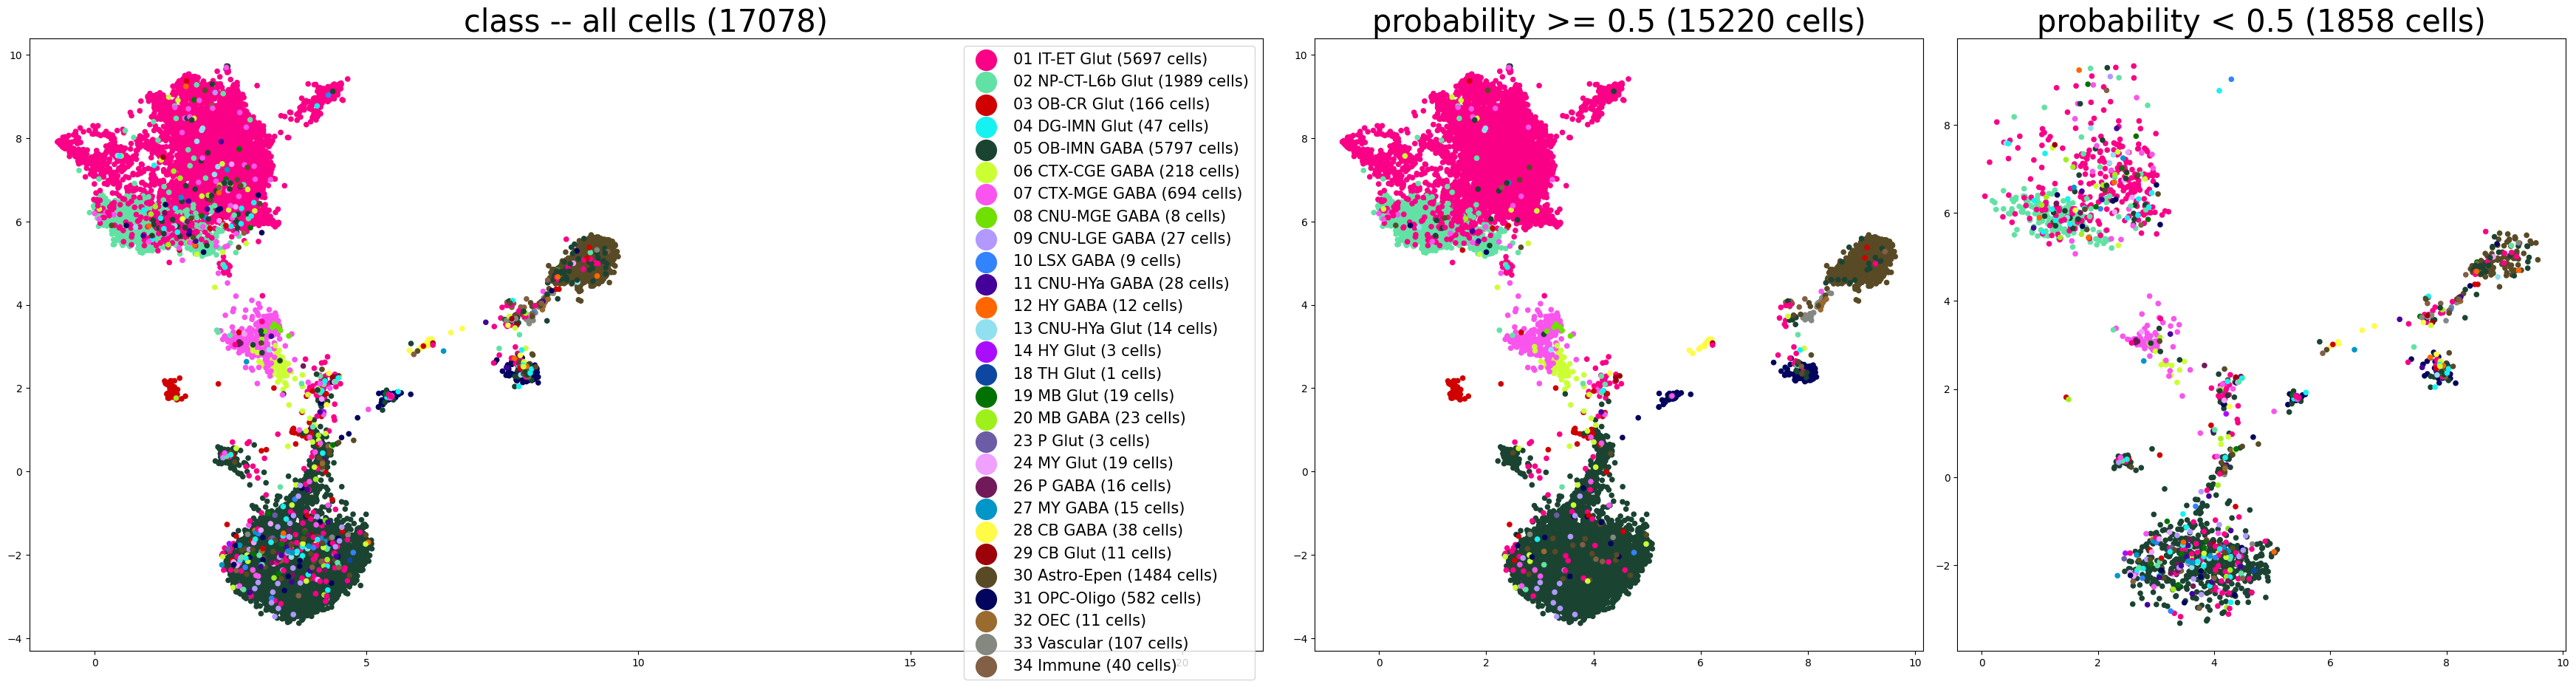

In [30]:
plot_umap(
    results=results,
    taxonomy_level='CCN20230722_CLAS',
    taxonomy_tree=taxonomy_tree,
    umap_df=umap_df,
    color_map=color_map,
    cut_on="probability",
    cut=0.5,
    size_unit=10,
    fontsize=15,
    marker_size=20,
    dst_path=fig_dir / 'class_p050_cut.png'
)

/var/folders/6w/ny22h74j3sz8jdt_69ljc9srvkqr8_/T/ipykernel_78560/2025945902.py:181: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


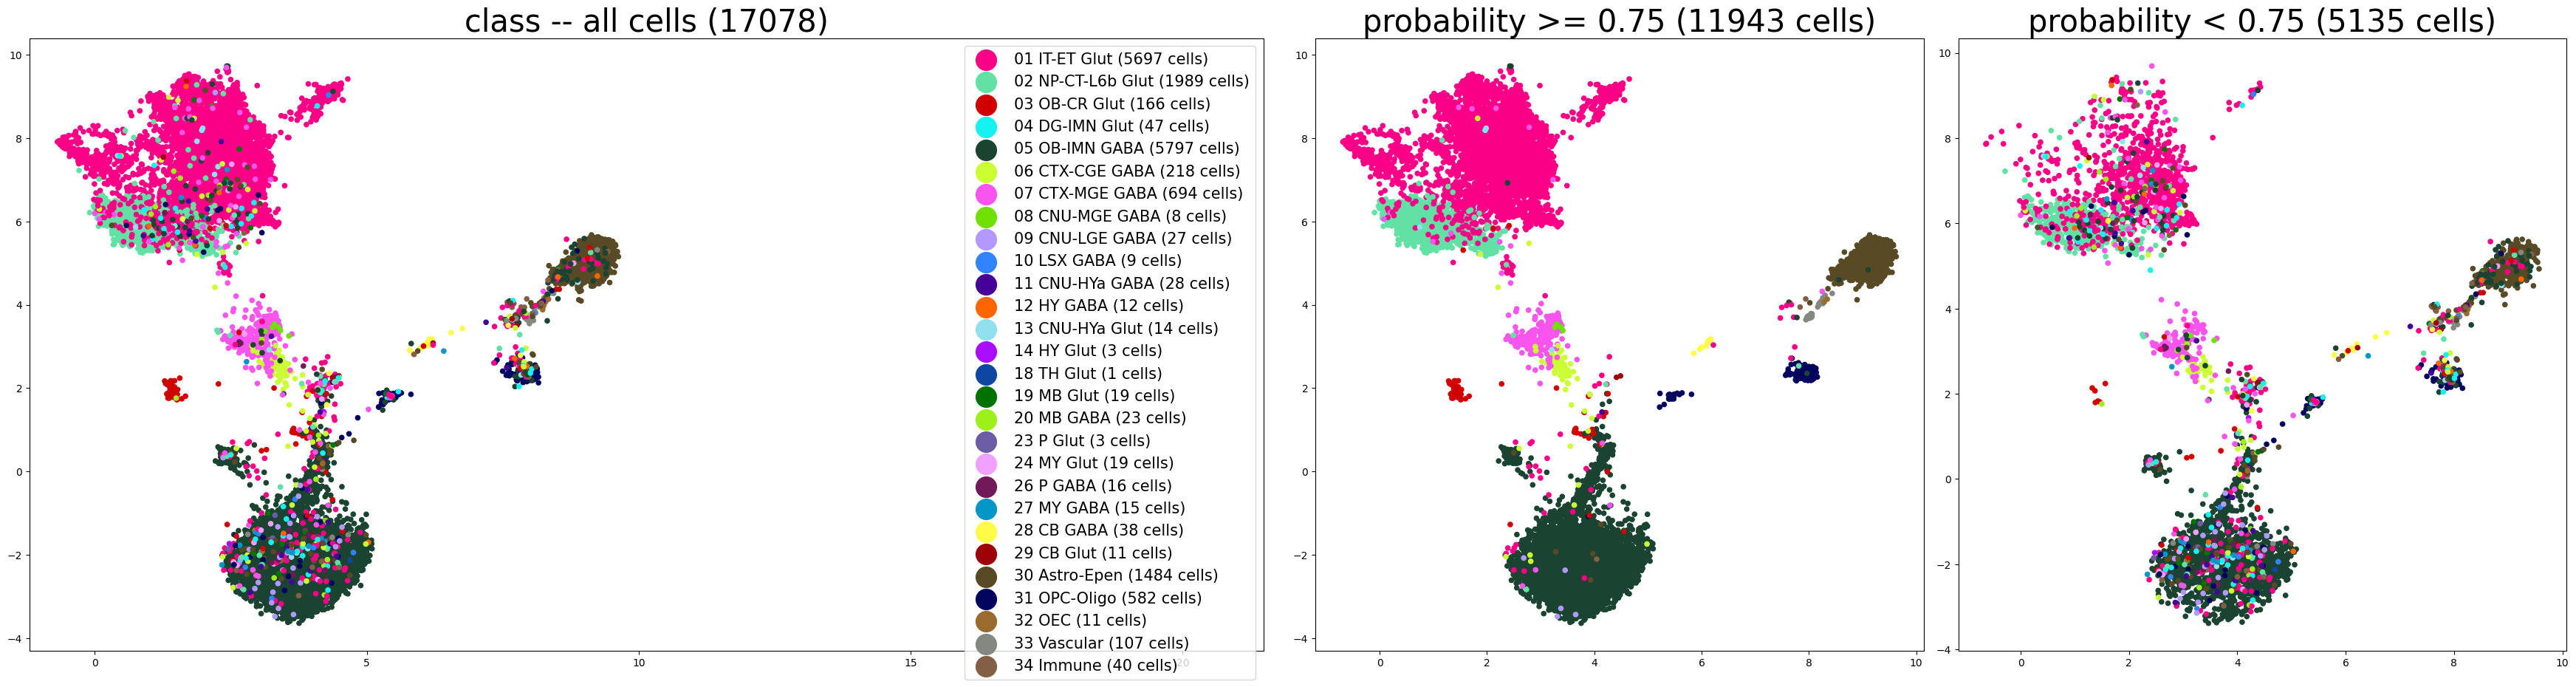

In [31]:
plot_umap(
    results=results,
    taxonomy_level='CCN20230722_CLAS',
    taxonomy_tree=taxonomy_tree,
    umap_df=umap_df,
    color_map=color_map,
    cut_on="probability",
    cut=0.75,
    size_unit=10,
    fontsize=15,
    marker_size=20,
    dst_path=fig_dir / 'class_p075_cut.png'
)

/var/folders/6w/ny22h74j3sz8jdt_69ljc9srvkqr8_/T/ipykernel_78560/2025945902.py:181: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


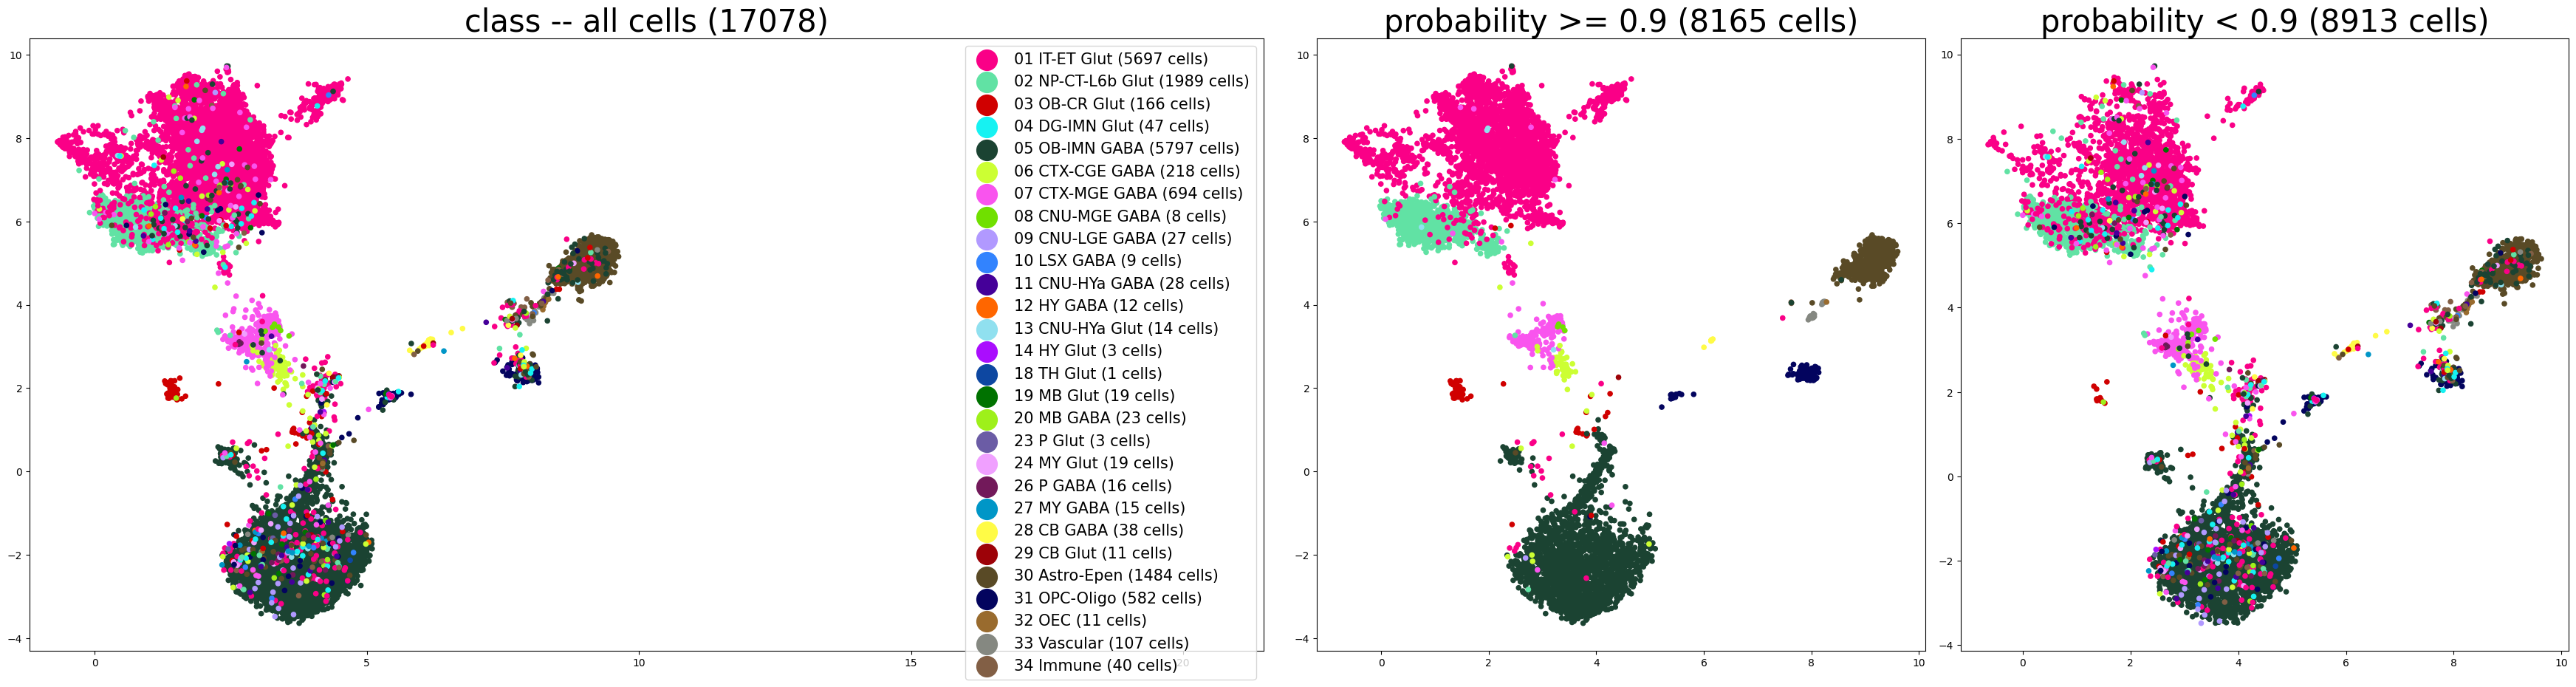

In [32]:
plot_umap(
    results=results,
    taxonomy_level='CCN20230722_CLAS',
    taxonomy_tree=taxonomy_tree,
    umap_df=umap_df,
    color_map=color_map,
    cut_on="probability",
    cut=0.9,
    size_unit=10,
    fontsize=15,
    marker_size=20,
    dst_path=fig_dir / 'class_p090_cut.png'
)

/var/folders/6w/ny22h74j3sz8jdt_69ljc9srvkqr8_/T/ipykernel_78560/2025945902.py:181: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


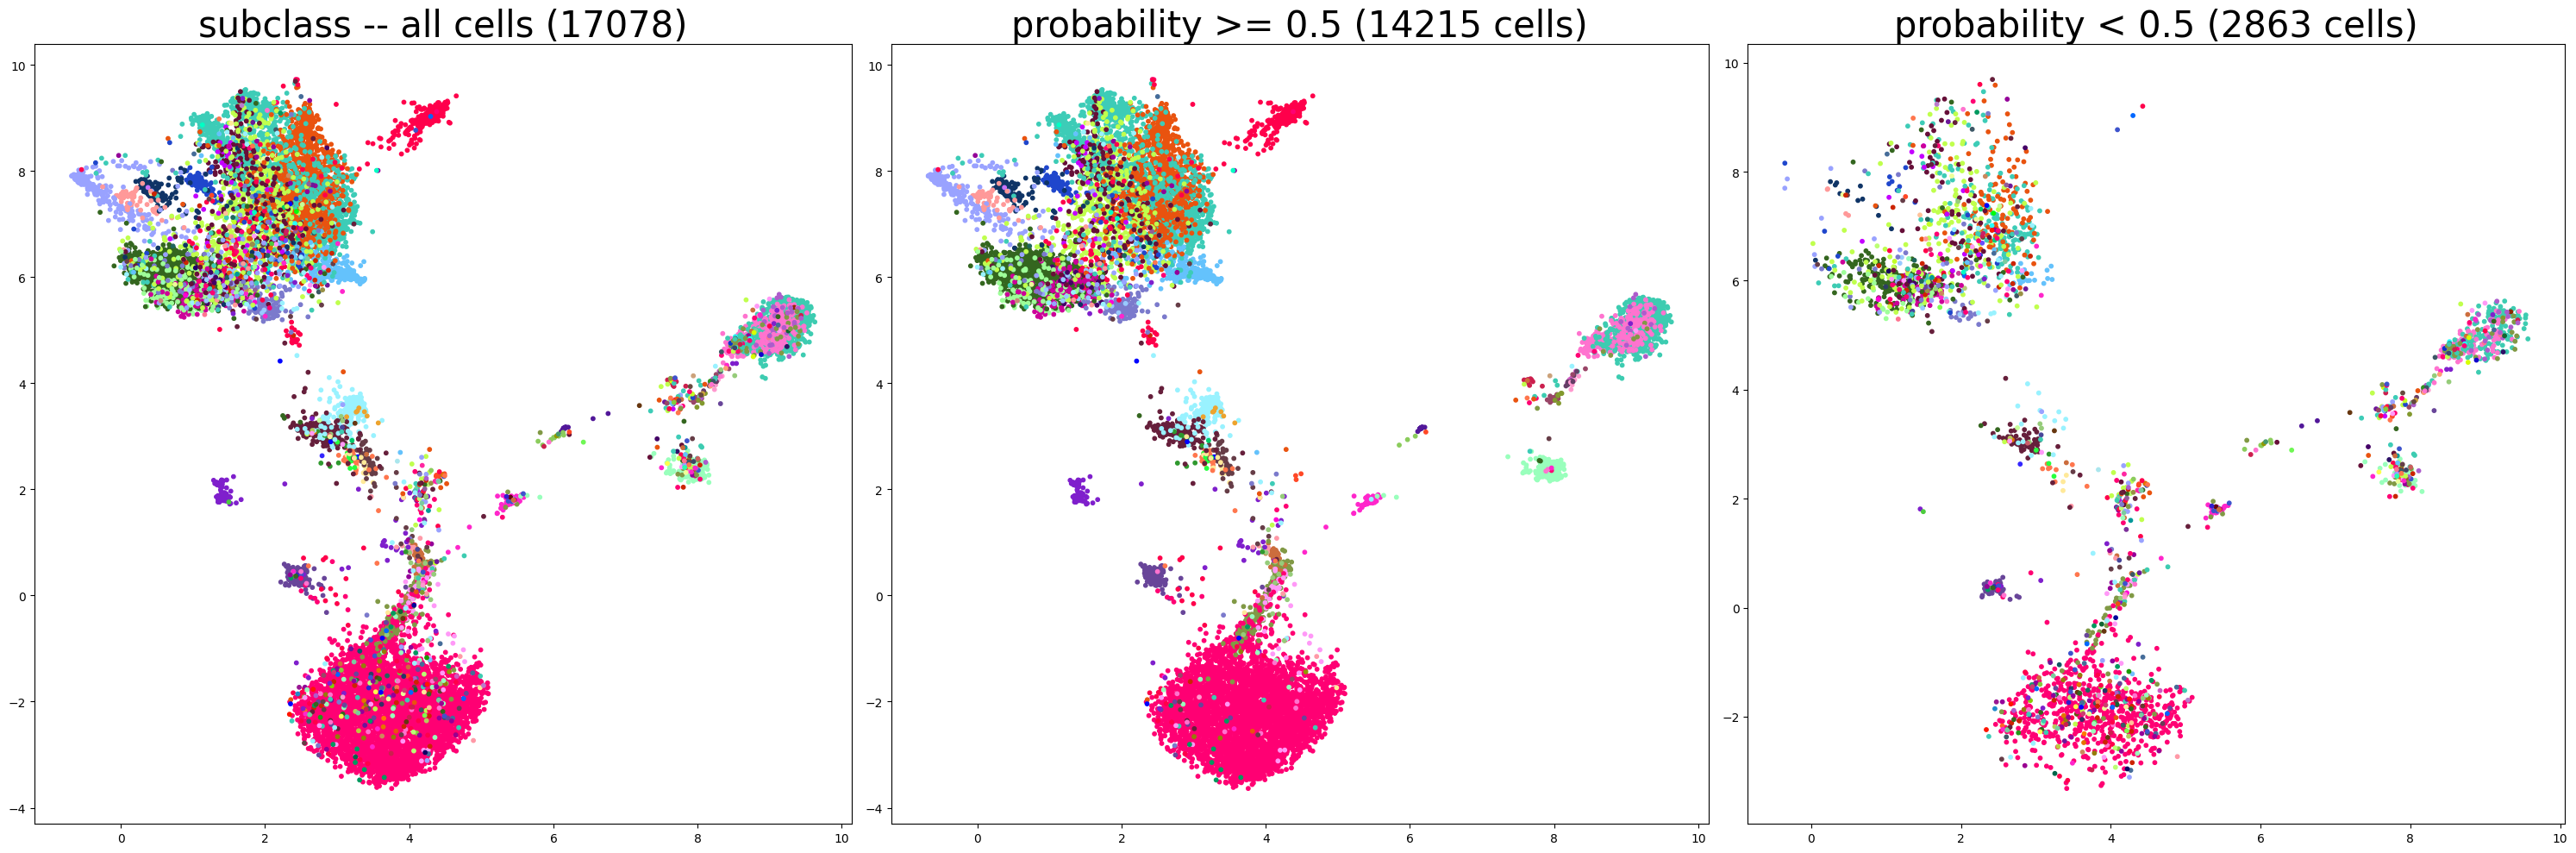

In [33]:
plot_umap(
    results=results,
    taxonomy_level='CCN20230722_SUBC',
    taxonomy_tree=taxonomy_tree,
    umap_df=umap_df,
    color_map=color_map,
    cut_on="probability",
    cut=0.5,
    size_unit=10,
    fontsize=15,
    marker_size=10,
    dst_path=fig_dir / 'subclass_p050_cut.png'
)

/var/folders/6w/ny22h74j3sz8jdt_69ljc9srvkqr8_/T/ipykernel_78560/2025945902.py:181: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


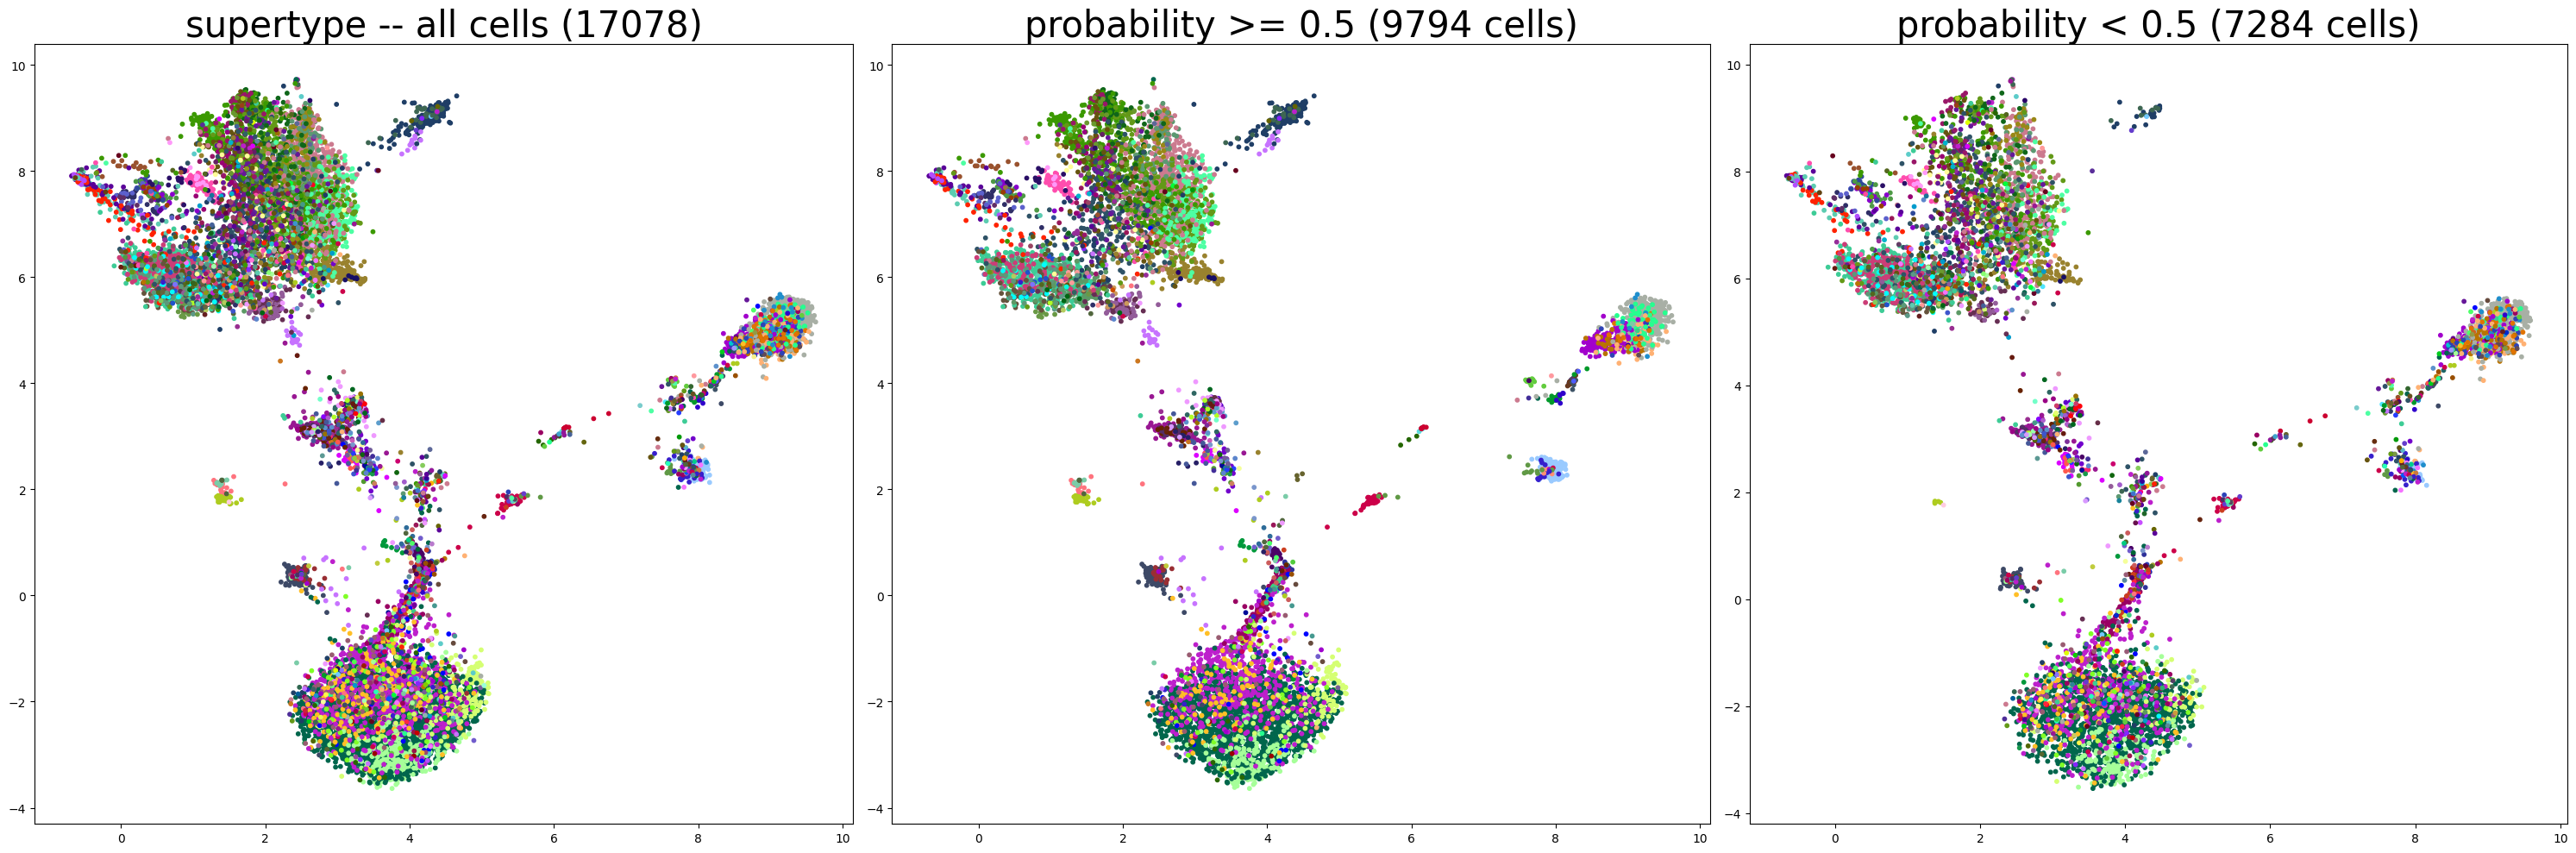

In [34]:
plot_umap(
    results=results,
    taxonomy_level='CCN20230722_SUPT',
    taxonomy_tree=taxonomy_tree,
    umap_df=umap_df,
    color_map=color_map,
    cut_on="probability",
    cut=0.5,
    size_unit=10,
    fontsize=15,
    marker_size=10,
    dst_path=fig_dir / 'supertype_p050_cut.png'
)

/var/folders/6w/ny22h74j3sz8jdt_69ljc9srvkqr8_/T/ipykernel_78560/2025945902.py:181: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


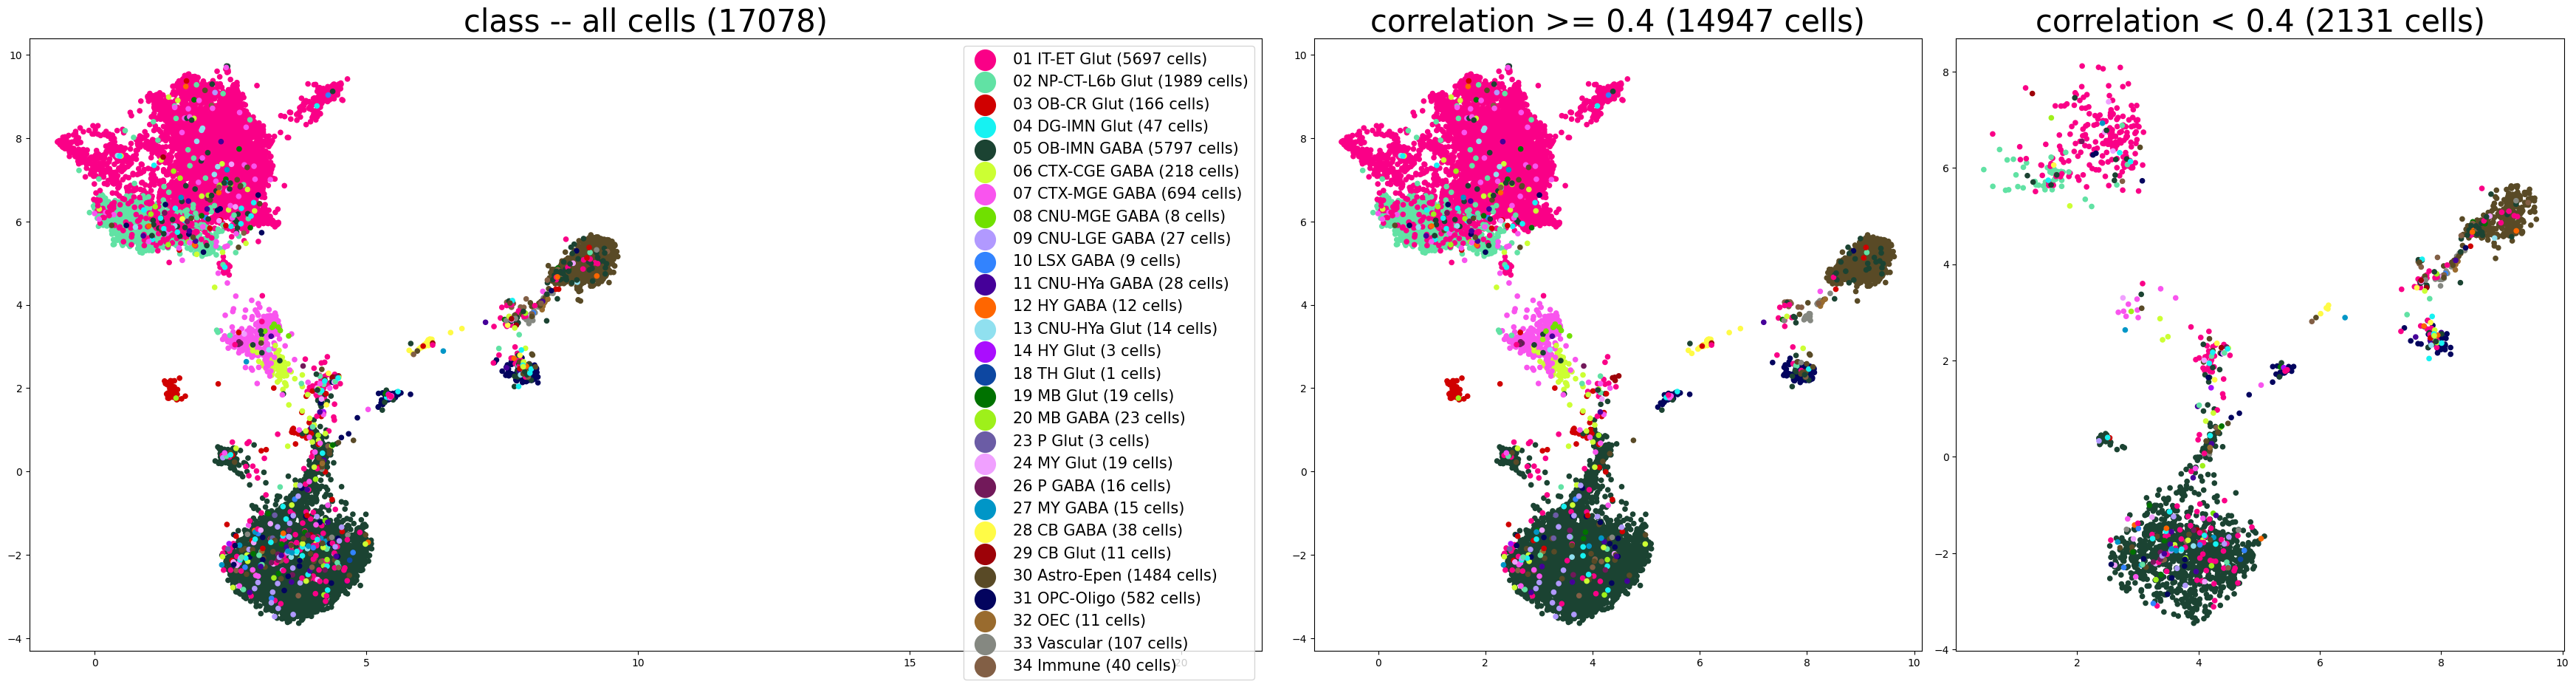

In [35]:
plot_umap(
    results=results,
    taxonomy_level='CCN20230722_CLAS',
    taxonomy_tree=taxonomy_tree,
    umap_df=umap_df,
    color_map=color_map,
    cut_on="correlation",
    cut=0.4,
    size_unit=10,
    fontsize=15,
    marker_size=20,
    dst_path=fig_dir / 'class_c040_cut.png'
)

/var/folders/6w/ny22h74j3sz8jdt_69ljc9srvkqr8_/T/ipykernel_78560/2025945902.py:181: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


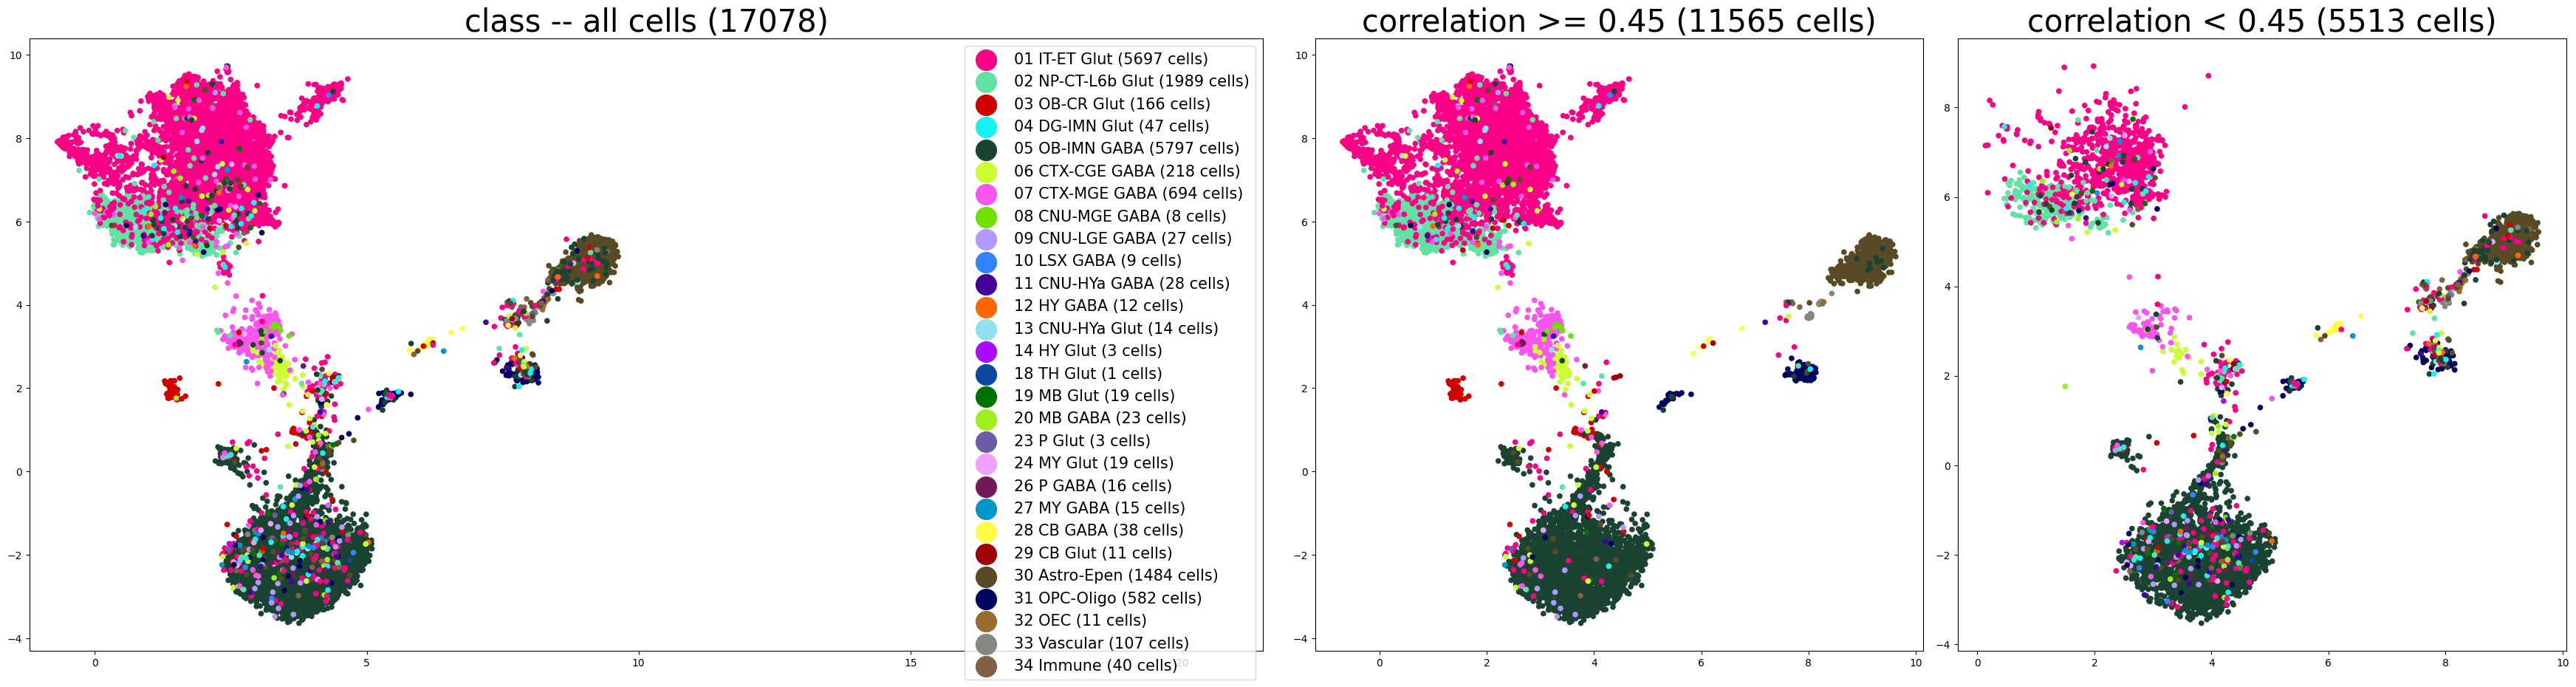

In [36]:
plot_umap(
    results=results,
    taxonomy_level='CCN20230722_CLAS',
    taxonomy_tree=taxonomy_tree,
    umap_df=umap_df,
    color_map=color_map,
    cut_on="correlation",
    cut=0.45,
    size_unit=10,
    fontsize=15,
    marker_size=20,
    dst_path=fig_dir / 'class_c045_cut.png'
)